# 因果効果推定手法の実装

LaLonde データセットを用いて、因果効果推定の主要な手法を実装・比較する。
- 回帰ベース（OLS）
- 傾向スコアマッチング（PSM）
- 逆確率重み付け（IPW）
- Doubly Robust 推定量

## 分析の構成

1. **真の因果効果（ベンチマーク）**: 実験データ（sample=1, RCT）から計算
2. **観察データでの推定**: treated=1（sample=1）とCPS対照群（sample=2, treated=0）を組み合わせた選択バイアスのあるデータで推定
3. **手法の比較**: 各手法が真の因果効果にどの程度近づけるかを評価

## LaLonde データセットについて

このデータセットは、National Supported Work (NSW) プログラムの効果を分析するために使用されます。

### 変数の定義

- **treated**: 処置変数（1 = 職業訓練プログラムに参加、0 = 非参加）
- **age**: 年齢（歳）
- **educ**: 教育年数（年）
- **black**: 人種ダミー（1 = 黒人、0 = その他）
- **hispan**: ヒスパニック系ダミー（1 = ヒスパニック、0 = その他）
- **married**: 結婚状況（1 = 既婚、0 = 未婚）
- **nodegree**: 学位なしダミー（1 = 高卒資格なし、0 = あり）
- **re74**: 1974年の実質所得（ドル）
- **re75**: 1975年の実質所得（ドル）
- **re78**: 1978年の実質所得（ドル）- アウトカム変数
- **early_ra**: Smith and Todd (2005) の早期ランダム割り当てサンプルへの包含を示す指標変数（実験サンプルに含まれない場合は欠損値）
- **sample**: サンプルの種類（1 = NSW実験サンプル、2 = CPS比較グループ、3 = PSID比較グループ）
- **experimental**: 実験サンプルに含まれるかどうか（1 = 実験サンプル、0 = それ以外）

### サンプルグループの説明

**1. NSW実験サンプル (sample=1)**
- National Supported Work (NSW) プログラムのランダム化比較試験（RCT）データ
- 処置群と対照群がランダムに割り当てられているため、因果効果の推定が容易
- 真の因果効果のベンチマークとして使用される

**2. CPS比較グループ (sample=2)**
- Current Population Survey（米国の雇用統計調査）から抽出された非実験的な対照群
- NSW処置群と比較するために構築された観察データ
- ランダム割り当てではないため、選択バイアスが存在する可能性

**3. PSID比較グループ (sample=3)**
- Panel Study of Income Dynamics（所得動態パネル調査）から抽出された非実験的な対照群
- CPSと同様に、観察データとしてNSW処置群との比較に使用
- より長期的な所得履歴データを含む

LaLonde (1986) とその後の研究では、実験データ（NSW）で得られた因果効果と、観察データ（CPSやPSID）を用いた非実験的手法で得られた推定値を比較することで、各種因果推論手法の妥当性を検証しています。


## 1. データの読み込みと前処理


In [11]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from causallib.estimation import IPW, PropensityMatching, StratifiedStandardization
from causallib.evaluation import evaluate

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load LaLonde dataset
df_org = pd.read_csv('data/input/ec675_nsw.tab', sep='\t')

print(f"Shape: {df_org.shape}")
print(f"\nColumns: {df_org.columns.tolist()}")
print(f"\nSample distribution:")
print(df_org['sample'].value_counts().sort_index())

Shape: (19204, 13)

Columns: ['treated', 'age', 'educ', 'black', 'married', 'nodegree', 'dwincl', 're74', 're75', 're78', 'hisp', 'early_ra', 'sample']

Sample distribution:
sample
1.0      722
2.0    15992
3.0     2490
Name: count, dtype: int64


In [3]:
# Check sample and treatment distribution
print("Sample × Treatment cross-tabulation:")
print(pd.crosstab(df_org['sample'], df_org['treated'], margins=True))

Sample × Treatment cross-tabulation:
treated  0.0  1.0  All
sample                
1.0      425  297  722
All      425  297  722


In [4]:
df_org.isna().sum()

treated     18482
age             0
educ            0
black           0
married         0
nodegree        0
dwincl      18482
re74            0
re75            0
re78            0
hisp            0
early_ra    18482
sample          0
dtype: int64

In [38]:
df_org['early_ra'].value_counts()

early_ra
0.0    472
1.0    250
Name: count, dtype: int64

## 2. 真の因果効果の計算（実験データから）

実験データ（sample=1）のみを使用して、RCTによる真の因果効果（True ATE）を計算します。
これがベンチマークとなります。

In [5]:
# Extract experimental data (sample=1) for TRUE ATE calculation
df_exp = df_org[df_org['sample'] == 1].copy()
df_exp = df_exp.dropna(subset=['treated', 're78'])

treatment_exp = df_exp['treated'].values
outcome_exp = df_exp['re78'].values

# TRUE ATE from RCT
true_ate = outcome_exp[treatment_exp == 1].mean() - outcome_exp[treatment_exp == 0].mean()

print("=" * 60)
print("TRUE CAUSAL EFFECT (from RCT - sample=1)")
print("=" * 60)
print(f"Treatment group (n={int((treatment_exp == 1).sum())}): Mean outcome = {outcome_exp[treatment_exp == 1].mean():.2f}")
print(f"Control group (n={int((treatment_exp == 0).sum())}): Mean outcome = {outcome_exp[treatment_exp == 0].mean():.2f}")
print(f"\n*** TRUE ATE = {true_ate:.2f} ***")
print("=" * 60)

TRUE CAUSAL EFFECT (from RCT - sample=1)
Treatment group (n=297): Mean outcome = 5976.35
Control group (n=425): Mean outcome = 5090.05

*** TRUE ATE = 886.30 ***


## 3. 観察データの準備（選択バイアスあり）

- **処置群**: sample=1 かつ treated=1（実験の処置群）
- **対照群**: sample=2 かつ treated=0（CPS比較グループ）

この組み合わせにより、選択バイアスが存在する観察データを構築します。

In [15]:
# Construct observational data with selection bias
# Treated: sample=1 & treated=1
# Control: sample=2 & treated=0 (CPS comparison group)
df_treated = df_org[(df_org['sample'] == 1) & (df_org['treated'] == 1)].copy()
df_control = df_org[(df_org['sample'] == 2)].copy().fillna({'treated': 0})

df_obs = pd.concat([df_treated, df_control], ignore_index=True)

print("=" * 60)
print("OBSERVATIONAL DATA CONSTRUCTION")
print("=" * 60)
print(f"Treated group (sample=1, treated=1): n={len(df_treated)}")
print(f"Control group (sample=2, treated=0): n={len(df_control)}")
print(f"Total observational sample: n={len(df_obs)}")
print("=" * 60)

# Prepare variables for observational data
treatment = df_obs['treated'].values
outcome = df_obs['re78'].values

# Covariates
y_col = 're78'
treat_col = 'treated'
X_cols = ['age', 'educ', 'black', 'married', 'nodegree', 're74', 're75']
X = df_obs[X_cols].values

naive_ate = outcome[treatment == 1].mean() - outcome[treatment == 0].mean()

print(f"\n観察データの基本統計:")
print(f"Treatment group size: {int((treatment == 1).sum())}")
print(f"Control group size: {int((treatment == 0).sum())}")
print(f"Mean outcome (treated): {outcome[treatment == 1].mean():.2f}")
print(f"Mean outcome (control): {outcome[treatment == 0].mean():.2f}")
print(f"\nNaive ATE (単純な群間比較): {naive_ate:.2f}")
print(f"Bias from TRUE ATE: {naive_ate - true_ate:.2f}")

OBSERVATIONAL DATA CONSTRUCTION
Treated group (sample=1, treated=1): n=297
Control group (sample=2, treated=0): n=15992
Total observational sample: n=16289

観察データの基本統計:
Treatment group size: 297
Control group size: 15992
Mean outcome (treated): 5976.35
Mean outcome (control): 14846.66

Naive ATE (単純な群間比較): -8870.31
Bias from TRUE ATE: -9756.61


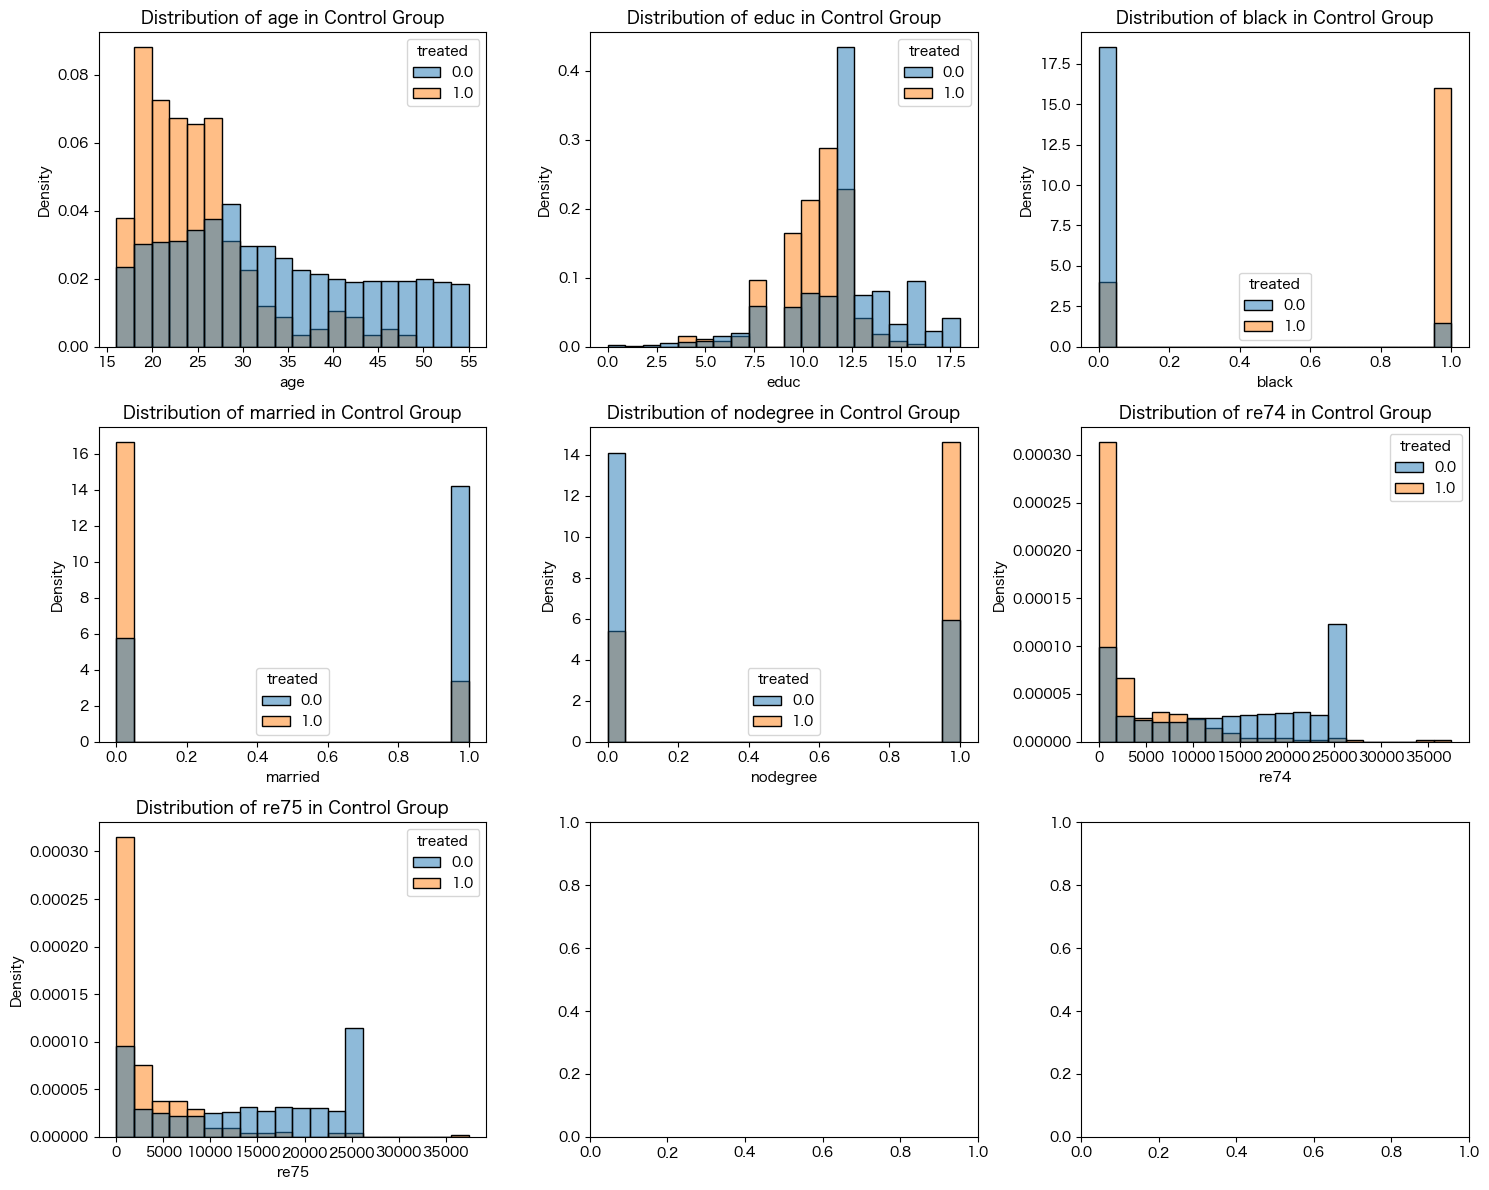

In [7]:
# df_controlの各カラムについて、histplotを作成

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
for i, col in enumerate(X_cols):
    ax = axes[i // 3, i % 3]
    sns.histplot(df_obs, x=col, hue='treated', bins=20, stat='density', common_norm=False, ax=ax)
    ax.set_title(f'Distribution of {col} in Control Group')
plt.tight_layout()

## 4. 回帰ベースの因果効果推定


In [22]:
# OLS regression-based estimation
X_reg = np.column_stack([treatment, X])
model_ols = LinearRegression()
model_ols.fit(X_reg, outcome)
ate_ols = model_ols.coef_[0]

print(f"OLS-based ATE: {ate_ols:.2f}")
print(f"Bias from TRUE ATE: {ate_ols - true_ate:.2f}")

OLS-based ATE: -1046.51
Bias from TRUE ATE: -1932.81


## 5. 傾向スコアの推定


In [9]:
# Estimate propensity scores
ps_model = LogisticRegression(max_iter=1000, random_state=42)
ps_model.fit(X, treatment)
y_pred = ps_model.predict_proba(X)
roc_auc_linear = roc_auc_score(treatment, y_pred[:,1])
propensity_scores = ps_model.predict_proba(X)[:, 1]

print(f"ROC AUC of Propensity Score Model: {roc_auc_linear:.4f}")
print(f"Propensity score range: [{propensity_scores.min():.4f}, {propensity_scores.max():.4f}]")
print(f"Treated group - mean PS: {propensity_scores[treatment == 1].mean():.4f}")
print(f"Control group - mean PS: {propensity_scores[treatment == 0].mean():.4f}")

ROC AUC of Propensity Score Model: 0.9550
Propensity score range: [0.0001, 0.5815]
Treated group - mean PS: 0.2922
Control group - mean PS: 0.0131


Text(0.5, 1.0, 'Propensity Score Distribution by Treatment Group')

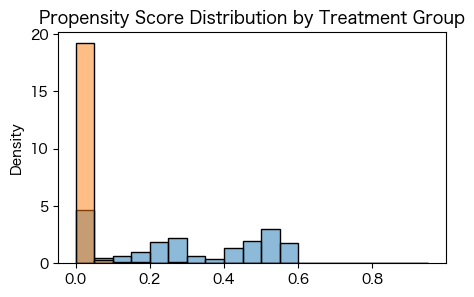

In [10]:
plot_kwargs = {
    'stat': 'density',
    'bins': np.arange(0, 1, 0.05),
    'alpha': 0.5,
}
# 傾向スコアの分布を可視化
plt.figure(figsize=(5, 3))
sns.histplot(propensity_scores[treatment == 1], label='Treated', **plot_kwargs)
sns.histplot(propensity_scores[treatment == 0], label='Control',  **plot_kwargs)
plt.title('Propensity Score Distribution by Treatment Group')

## 6. 傾向スコアマッチング（PSM）


In [16]:
pm = PropensityMatching(learner=ps_model, n_neighbors=1)
pm.fit(df_obs[X_cols], df_obs[treat_col], df_obs[y_col])

,learner,LogisticRegre...ndom_state=42)
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a w

In [18]:
outcomes = pm.estimate_population_outcome(df_obs[X_cols], df_obs[treat_col])
effect = pm.estimate_effect(outcomes[1], outcomes[0])

In [27]:
# # 4. マッチング後のバランス確認 (主要な手順)
# # PropensityMatchingオブジェクトに対して get_balance_metrics() を呼び出します。
# print("\n--- マッチング後の共変量バランス確認 ---")

# # get_balance_metrics() を使用して、SMD (標準化された平均差) を計算
# balance_df = pm.match_estimator.get_balance_metrics(X, a)

# # 結果の表示と解釈
# print("\n標準化された平均差 (SMD) の結果 (SMD_post_match の小さい順):")
# # SMD_post_match の値が 0.1 以下であることが望ましい基準です。
# print(balance_df[['SMD_post_match']].sort_values(by='SMD_post_match', ascending=True).head(10)) 

# max_smd = balance_df['SMD_post_match'].max()
# smd_ok = '✅' if max_smd <= 0.1 else '❌'

# print(f"\nすべての共変量の中で最も大きい SMD (マッチング後): {max_smd:.4f} {smd_ok}")
# print(f" (推奨基準: 0.1 以下。この値が大きい場合はバランスが不十分です。)\n")

# # 5. バランスの視覚化
# print("--- バランスの視覚的確認 ---")
# # plot_balance() を使用して、マッチング前後のSMDを比較します。

# # グラフを表示
# plot_balance(balance_df)
# plt.title('Covariate Balance before and after Propensity Matching')
# plt.show()

## 7. 逆確率重み付け（IPW）


In [31]:
ipw = IPW(learner=ps_model)
ipw.fit(df_obs[X_cols], df_obs[treat_col], df_obs[y_col])

outcomes = ipw.estimate_population_outcome(df_obs[X_cols], df_obs[treat_col], df_obs[y_col])
effect = ipw.estimate_effect(outcomes[1], outcomes[0])

In [33]:
effect

diff   -7549.069988
dtype: float64

<Axes: xlabel='Absolute Standard Mean Difference', ylabel='Covariates'>

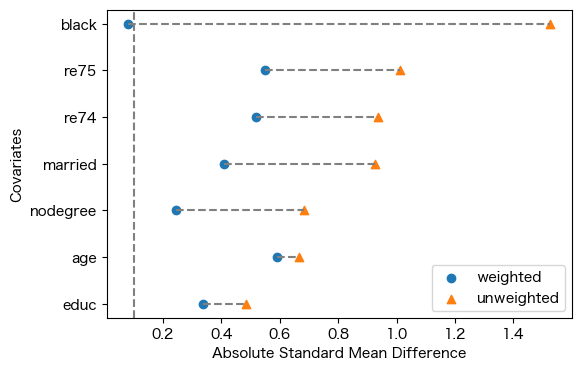

In [36]:
results = evaluate(ipw, df_obs[X_cols], df_obs[treat_col], df_obs[y_col])
fig, ax = plt.subplots(figsize=(6, 4))
results.plot_covariate_balance(kind='love', ax=ax, thresh=0.1)

<Axes: title={'center': 'Propensity Distribution'}, xlabel='Propensity', ylabel='Probability density'>

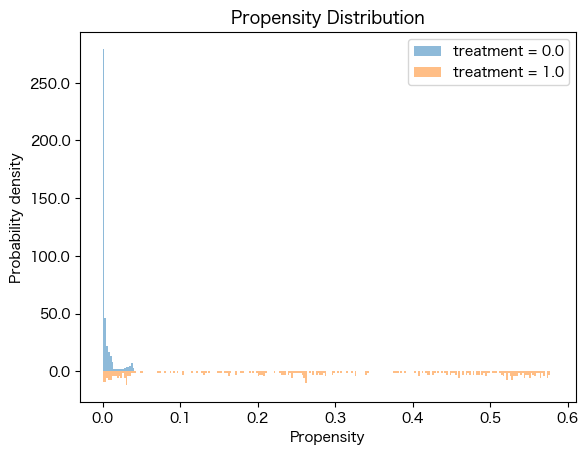

In [39]:
results.plot_weight_distribution()

In [35]:
# scratchで実装するコード

# # IPW (Inverse Probability Weighting)
# # ps_clipped = np.clip(propensity_scores, 0.01, 0.99)
# ps_clipped = np.clip(propensity_scores, 0.1, 0.9)

# # Weights: treatment group: 1/PS, control group: 1/(1-PS)
# weights = np.where(df_obs[treat_col] == 1, 1 / ps_clipped, 1 / (1 - ps_clipped))

# # Weighted ATE
# treat_index = df_obs[treat_col] == 1
# control_index = df_obs[treat_col] == 0
# treated_weighted = np.sum(weights[treat_index] * outcome[treat_index]) / np.sum(weights[treat_index])
# control_weighted = np.sum(weights[control_index] * outcome[control_index]) / np.sum(weights[control_index])
# ate_ipw = treated_weighted - control_weighted

# print(f"IPW-based ATE: {ate_ipw:.2f}")
# print(f"Bias from TRUE ATE: {ate_ipw - true_ate:.2f}")

## 8. Doubly Robust 推定量


In [ ]:
# Fit regression models for outcome prediction
# Model for treated: E[Y|X, T=1]
treated_mask = treatment == 1
reg_treated = LinearRegression()
reg_treated.fit(X[treated_mask], outcome[treated_mask])
pred_y1 = reg_treated.predict(X)

# Model for control: E[Y|X, T=0]
control_mask = treatment == 0
reg_control = LinearRegression()
reg_control.fit(X[control_mask], outcome[control_mask])
pred_y0 = reg_control.predict(X)

# Doubly Robust estimator
ps_clipped = np.clip(propensity_scores, 0.01, 0.99)

# ATE_1 component: treated units
component1 = (treatment * (outcome - pred_y1) / ps_clipped) + pred_y1

# ATE_0 component: control units
component0 = ((1 - treatment) * (outcome - pred_y0) / (1 - ps_clipped)) + pred_y0

ate_dr = component1.mean() - component0.mean()

print(f"Doubly Robust ATE: {ate_dr:.2f}")
print(f"Bias from TRUE ATE: {ate_dr - true_ate:.2f}")

Doubly Robust ATE: 818.15


## 9. 結果の比較


In [ ]:
# Summary of results
results = {
    'Method': ['TRUE ATE (RCT Benchmark)', 
               'Naive (Unadjusted)', 
               'Regression-based (OLS)', 
               'Propensity Score Matching', 
               'Inverse Probability Weighting', 
               'Doubly Robust'],
    'ATE': [true_ate,
            naive_ate,
            ate_ols, 
            ate_psm, 
            ate_ipw, 
            ate_dr],
    'Bias': [0,
             naive_ate - true_ate,
             ate_ols - true_ate,
             ate_psm - true_ate,
             ate_ipw - true_ate,
             ate_dr - true_ate]
}

results_df = pd.DataFrame(results)
print("\n" + "=" * 70)
print("因果効果推定結果の比較")
print("=" * 70)
print(results_df.to_string(index=False))
print("=" * 70)
print(f"\n解釈:")
print(f"- TRUE ATE: 実験データ（RCT）から得られた真の因果効果")
print(f"- Naive: 共変量調整なしの単純な群間差（バイアス大）")
print(f"- 各手法が真の因果効果にどれだけ近づけているかを確認")

Causal Effect Estimation Results
                   Method        ATE
       Naive (Unadjusted) 886.303822
         Regression-based 822.991814
Propensity Score Matching 737.628977
                      IPW 816.111031
            Doubly Robust 818.151493
